# Anonymous Recursive Functions in Python

## or, How to Square the Square Root of a Function

#### Brian Beckman

#### 4 Nov 2022

# Prologue

This is a Python version of the Mathematica notebook, [YCombinator005.nb](https://github.com/rebcabin/rebcabin.github.io/blob/main/YCombinator005.nb), with [PDF File](https://github.com/rebcabin/rebcabin.github.io/blob/main/YCombinator005.pdf). The primary difference between the Mathematica and Python versions is that we can write [static types](https://docs.python.org/3.10/library/typing.html) in Python. Static types afford the hope of compilation to fast machine code. 

Though Python does not actually check static types, various tools like [mypy](http://mypy-lang.org/) and [PyCharm](https://www.jetbrains.com/pycharm/download/#section=mac) check them and produce warnings on errors.  

The code in this notebook passes PyCharm's type-checking. It has two errors under mypy for two cyclic (recursive) type definitions. I do not know a way around this, but I don't consider it serious. After all, the entire topic is "recursion." PyCharm's type checker evidently tolerates my recursive types. Also, there are new typing services in Python 3.10 that I might try later.

I present the dynamically-typed theory, like the original Mathematica, then follow up with static types that can be compiled, say by [LPython](https://lpython.org).

# Introduction

Imagine a simplistic Python server that lets us evaluate expressions one at a time, but does not let us define functions or global variables. Why such restrictions? So that users can't fill up server memory with definitions in a putative denial-of-service attack.

For an example, I'd like to compute the factorial of a certain number, say 6, but the server doesn't offer a built-in for factorial. If I could define functions, I'd first send up

In [1]:
def factorial_recursive(n: int) -> int:
    result = 1 if (n < 1) else n * factorial_recursive(n - 1)
    return result

and then, later, send up

In [2]:
factorial_recursive(6)

720

But that's two shots, and I only get one shot. Am I out of luck? No. In fact, the following does the trick, as this article explains:

In [3]:
((lambda d:
  (lambda g: g(g))
  (lambda sf:  # <~~~ square root of 'f'
   d(lambda m: (sf(sf))(m))))  # <~~~ ... sf squared
 (lambda f:
  (lambda n:         # v~~~ f at work
   1 if n < 1 else n * f(n - 1))))(6)  # <~~~ business end

720

That's a flurry of symbols, I know, but this article makes it clear, I promise. See the business end, where, seemingly magically, `f` has become the recursive function _factorial_? `f` is the "square" of the "square root" `sf` of factorial, where "squaring a function" means "applying the function to itself."

## Bonus: Fast Fibonacci

As a bonus, I show how to _memoize_ [sic] anonymous recursive functions to reduce their run-time complexity. Memoizing is a kind of [_dynamic programming_](https://en.wikipedia.org/wiki/Dynamic_programming).

# Anonymous Functions

We already know how to define anonymous functions: [Python's lambda expressions](https://docs.python.org/3.10/reference/expressions.html?highlight=lambda#lambda). Here is one that computes its argument `x` times its argument plus 1, `(x + 1)`:

In [4]:
(lambda x: x * (x + 1))

<function __main__.<lambda>(x)>

In the expression above, `x` is a _formal parameter_. It gets the value of its _actual argument_ through _function application_, as follows, with the argument following the lambda in parentheses or round brackets:

In [5]:
(lambda x: x * (x + 1))(6)

42

## Notation

In the following, script letters like $\mathscr{D}$ , $\mathscr{E}$, $\mathscr{F}$, and $\mathscr{Y}$, are _notional names_: names we can't write for the one-shot Python server, but names of things we need to think about and don't want to keep writing out over and over again. For example, we'll see the following multiple times:


    (lambda d:
     (lambda g: g(g))
     (lambda sf:
      d(lambda m: (sf(sf))(m))))


That's a literal, denotable expression that we send to the server as part of other expressions. But it's too much to look at while thinking, so we just call it $\mathscr{Y}$ for the sake of discussion. In fact, explaining $\mathscr{Y}$ is the whole point of this article. It's a gadget that passes the delayed square of `sf` into domain code `d` for application. It pulls the square root magically out of a hat.

# Recursion as Squaring the Square Root

We want `fact`, but the server doesn't let us define or name `fact`. But the server _does_ give us temporary names that go away in one shot: formal parameters of lambda expressions. So if we can name $\sqrt{\mathtt{fact}}$ as a parameter and then apply it to itself -- square it -- we get the same effect as `fact`. 

More generally, for any function $\mathscr{F}$, pass $\sqrt{\mathscr{F}}$ as an actual argument to $\sqrt{\mathscr{F}}$. Bind the actual argument $\sqrt{\mathscr{F}}$ to the parameter `sf`. In the body of $\sqrt{\mathscr{F}}$, refer to $\mathscr{F}$ by the expression $\mathtt{sf(sf)}=\sqrt{\mathscr{F}}\left(\sqrt{\mathscr{F}}\right)=\left(\sqrt{\mathscr{F}}\right)^2= \mathscr{F}$. Square the square root by self-application to get the recursive function $\mathscr{F}$ that we want. What a great trick! 

Turns out we can easily compute $\sqrt{\mathscr{F}}$ for any function $\mathscr{F}$. We do `fact` and `fib` as examples, then generalize. As a bonus, we speed up `fib` with a reusable technique.

## The Square Root of Factorial

To get the square root of factorial, just _assume it exists_ and has a name, `sf`, in the only allowed place, as the parameter of a lambda expression. Notionally, call the lambda expression $\sqrt{\mathscr{F}}$. In the body of $\sqrt{\mathscr{F}}$, apply `sf(sf)`, the square of `sf`, wherever you want factorial, $\mathscr{F}$. What is the value of `sf`? Just $\sqrt{\mathscr{F}}$ itself! So $\sqrt{\mathscr{F}}\left(\sqrt{\mathscr{F}}\right)$ must be factorial, and we can apply it to numerical arguments:

In [6]:
((lambda sf: (lambda n: 1 if n < 1 else n * sf(sf)(n - 1)))
 (lambda sf: (lambda n: 1 if n < 1 else n * sf(sf)(n - 1))))(6)

720

> The technique of assuming something exists and then reasoning about its properties is as old as Pythagoras. The Pythagoreans discovered that $\sqrt{2}$, while the length of the hypotenuse of a right triangle with unit legs, is not a rational number, and they denied its existence, yet knowing its square. They were so appalled by this discovery that they instituted the death penalty for revealing it. It's possible that they executed [Hippasus](https://en.wikipedia.org/wiki/Hippasus) for revealing it. Similar stories surround the discoveries of 0, negative numbers, transcendental numbers, imaginary numbers, quaternions, and more. These were all disturbing violations of the prior known rules that only made sense through their implications. 

Before the final actual argument, `6`, there is a lambda expression $\sqrt{\mathscr{F}}$=`(lambda sf: ...)` of one parameter `sf`. That lambda expression is
applied to a cut-and-paste copy of its whole self. That self-application,  


    ((lambda sf: ...)(lambda sf: ...))


squares $\sqrt{\mathscr{F}}$. Inside the recursive body -- inside the business part `(... if ... else ...)` -- there is a similar self-application, `sf(sf)`, applied to a numerical argument, `n - 1`. The external squaring, `((lambda sf: ...)(lambda sf: ...))` produces the same result as the internal squaring `sf(sf)`. 

That's it! 

Stop here if all you care about is a programming pattern for anonymousa recursive functions: just replace the business part -- `(... if ... else ...))` -- in both copies where it occurs, with your desired business code, and call your recursive function via the reusable self-application syntax `sf(sf)`. 

However, there are worthwhile improvements. We can automate the programming pattern. We can write a general function $\mathscr{Y}$ that squares the square root of any function $\mathscr{F}$. We can avoid all copy-paste code. That's a big deal! _Don't Repeat Yourself_ is a foundational principle of software engineering, a principle that avoids pitfalls in development and maintenance. 

# Four Improvements: Two Abstractions, One Model, Packaging

Let's make a ***combinator*** (a function of a function) that can convert any function into a new function that receives its self application, `f=sf(sf)`, as its first argument. This is a twist on the prior development. We want `sf(sf)` as the value of the first parameter `f`. We want to write `((...)(lambda f: (lambda n: ...))(6)` in our example, with `(lambda f: (lambda n: ...))` as the ***domain function*** `sf(sf)` and `(lambda n: ...)` as the ***business function***. Solve for `(...)`.

First, start with the prior development, in which `sf` is the parameter in a cut-and-paste squaring of $\sqrt{\mathscr{F}}$. Inside the business code, replace `sf(sf)` by the parameter `f` of that new anonymous function of `f`, the domain function. Apply the new anonymous function of `f`  to `sf(sf)`. 

> In general, ***abstraction*** means replacing an expression $\mathscr{E}$ with a parameter `e` of a new anonymous function, then applying that new anonymous function to $\mathscr{E}$ as an actual argument, which becomes the value of the parameter `e`. 

> $\ldots\mathscr{E}\ldots\rightsquigarrow\texttt{(lambda e :}\ldots\texttt{e}\ldots\texttt{)}(\mathscr{E})$ 

> This is how, in general, you give actual but temporary names like `e` in your programming language to notional objects like $\mathscr{E}$ -- things you can write down spelled out in the programming language but can't give a name to, directly.

Second, abstract the domain code into a parameter `d` of the final, general combinator $\mathscr{Y}$ (a notional name only) so that we write the domain code only once. 

Here are all the improvements, spelled out for factorial:

## Step 1: Abstract the Internal Self-Application

The fragment on each line, below, is the new abstracted function of `f` applied to `sf(sf)`. However, this new abstraction fails to terminate even before applied to a numerical argument:

In [7]:
((lambda sf: (lambda f: (lambda n: 1 if n < 1 else n * f(n - 1)))(sf(sf)))
 (lambda sf: (lambda f: (lambda n: 1 if n < 1 else n * f(n - 1)))(sf(sf))))

RecursionError: maximum recursion depth exceeded

Why? Let's calculate. Let $\mathscr{s}\mathscr{F}$, notionally, stand for this function of `sf` that binds `sf(sf)` to the parameter `f`:

In [8]:
𝓈ℱ = ( lambda sf: (lambda f: (lambda n: 1 if n < 1 else n * f(n - 1)))(sf(sf)) )

In [9]:
𝓈ℱ

<function __main__.<lambda>(sf)>

So far, so good, no blowing up! Apply $\mathscr{s}\mathscr{F}$ -- this function of `sf` -- to a copy of itself exactly as before: 

In [10]:
𝓈ℱ(𝓈ℱ)

RecursionError: maximum recursion depth exceeded

This can't work. The argument `sf(sf)` is evaluated to $\mathscr{s}\mathscr{F}\left(\mathscr{s}\mathscr{F}\right)$ before being bound to `f` , but there we go evaluating `sf(sf)` again before knowing what it is! 

> That is ***applicative-order evaluation*** or ***call-by-value*** -- evaluate arguments before applying the function. It's the norm in most practical programming languages like Mathematica, Scheme, Python, C/C++, etc. It's too early for this job. 

This unbounded recursion has nothing to do with the business code inside `(lambda f: ...)`; we never get there. The following has trivial business code and also blows up:

In [11]:
((lambda sf: (lambda f: (lambda n: 0))(sf(sf)))
 (lambda sf: (lambda f: (lambda n: 0))(sf(sf))))

RecursionError: maximum recursion depth exceeded

### Delay the Squaring

Delay evaluation of `sf(sf)` by redefining $\mathscr{s}\mathscr{F}$ to internally apply, instead of `f` to the numerical argument `n - 1`,

In [12]:
(lambda m: sf(sf)(m))

<function __main__.<lambda>(m)>

as follows:

In [13]:
(lambda sf: 
 (lambda f: 
  (lambda n: 1 if n < 1 else n * f(n - 1)))\
 (lambda m: sf(sf)(m)))

<function __main__.<lambda>(sf)>

`(lambda m: sf(sf)(m))`$(\mathscr{N})$, always has the same value as `sf(sf)`$(\mathscr{N})$. The two expressions just evaluate `sf(sf)` at different times. In the first case, `sf(sf)` is evaluated later when `(lambda m: sf(sf)(m))` is applied to $\mathscr{N}$. The enclosing `lambda` means "_evaluate my guts later, when things might be better defined_." In the second case, `sf(sf)` is evaluated first, before being applied to $\mathscr{N}$, but that's too early.

> A general technique for delaying the application of any function: replace the application with a new function of some (any) parameter.

> $f(n)\rightsquigarrow\left(\texttt{lambda m : }f(m)\right)\left(n\right)$

> In lazy languages like Haskell, this step is automatic and implicit -- we don't write it -- because evaluation is always delayed. That's similar to normal-order evaluation, maybe even equivalent.

Let's back off and write our very first original self-application with `(lambda m: sf(sf)(m))` manually in place of `f`.

In [14]:
((lambda sf: 
  (lambda n: 1 if n < 1 else n * (lambda m: sf(sf)(m))(n - 1)))
 (lambda sf: 
  (lambda n: 1 if n < 1 else n * (lambda m: sf(sf)(m))(n - 1))))(6)

720

the result does not spin forever because evaluation of `sf(sf)` is delayed until needed on the argument $n=6$.

Now, as before, abstract `(lambda m: sf(sf)(m)`, merely a delayed version of `sf(sf)`, into a parameter `f` of a new lambda, the domain function:

In [15]:
((lambda sf: 
  (lambda f:
   (lambda n: 1 if n < 1 else n * f(n - 1)))
  (lambda m: sf(sf)(m)))
 (lambda sf: 
  (lambda f:
   (lambda n: 1 if n < 1 else n * f(n - 1)))
  (lambda m: sf(sf)(m))))(6)

720

## Step 2: Abstract the Domain Code

The abstraction on `f` now completely and minimally encloses the domain code :

In [16]:
𝒟 = (lambda f: (lambda n: 1 if n < 1 else n * f(n - 1)))

but $\mathscr{D}$ is still copy-pasted. Abstract it:

1. Write a new function $\mathscr{H}$ of a parameter `d` ... 
2. ... with a body that replaces $\mathscr{D}$, the old function of `f`, with `d`.
3. Apply $\mathscr{H}$ of `d` to $\mathscr{D}$

In [17]:
((lambda d:  # this is the new ℋ(d)
  (lambda sf: d(lambda m: sf(sf)(m)))
  (lambda sf: d(lambda m: sf(sf)(m))))
 (lambda f:  # this is the old 𝒟
  (lambda n: 1 if n < 1 else n * f(n - 1))))(6)

720

We still have some copy-paste repetion. Let's get rid of it ...

## Step 3: Model the Self-Application

... by abstraction again! Write a function `(lambda g: g(g))` that just self-applies any other function. Replace the self-application 


    (lambda sf: d(lambda m: sf(sf)(m)))
    (lambda sf: d(lambda m: sf(sf)(m)))


with an application of `(lambda g: g(g))` to `(lambda sf: d(lambda m: sf(sf)(m)))`:

In [18]:
((lambda d: 
  (lambda g: g(g))
  (lambda sf: 
   d(lambda m: sf(sf)(m))))
 (lambda f:  # this is 𝒟
  (lambda n: 
   1 if n < 1 else n * f(n - 1))))(6)

720

We're done! That's the same expression we had in cell no. 3 up top.

### Demonstrate the Generality

Try the outer combinator -- which always stays the same -- on some new domain code, which we only write once. This is slow Fibonacci, as we shall see:

In [19]:
((lambda d: (lambda g: g(g))
  (lambda sf: 
   d(lambda m: sf(sf)(m))))
 (lambda f:  # this is 𝒟
  (lambda n: 
   1 if n < 2 else f(n - 1) + f(n - 2))))(6)

13

## Step 4: Package as a Combinator

Package the outer combinator as a notional function $\mathscr{Y}$:

In [20]:
𝒴 = (lambda d: (lambda g: g(g))
      (lambda sf: d(lambda m: sf(sf)(m))))

and test on our two examples

In [21]:
𝒴(lambda f: 
   (lambda n: 
    1 if n < 1 else n * f(n - 1)))(6)

720

In [22]:
𝒴(lambda f: 
   (lambda n: 
    1 if n < 2 else f(n - 1) + f(n - 2)))(6)

13

# Static Types

Let's write static types. Why? Because a compiler might generate fast code if it knew the types; and, because it's interesting. We leave the world of lambdas and enter the world of `def`, so we must temporarily forget about the one-shot server.

## $\mathscr{D}$, Domain Code: FI2I to FI2I

The busines code for factorial, `(lambda n: 1 if n < 1 ...)`, is a function from an integer `n` to an integer, a type that we call `FI2I`:

In [23]:
from typing import Callable
FI2I = Callable[[int], int]  # int -> int

> [Type aliases](https://docs.python.org/3.10/library/typing.html#type-aliases) might improve on the technique in this article.

The input to $\mathscr{Y}$ is $\mathscr{D}$, the _domain code_. $\mathscr{D}$ is a function of `f`. We have already deduced that `f` must be $\mathscr{F}$ = factorial, type `FI2I`. $\mathscr{D}$ takes a `FI2I`, `f`, and returns the business function, also of type `FI2I`. $\mathscr{D}$ must be of type `FI2I` $\rightarrow$ `FI2I`. Here is $\mathscr{D}$ for factorial:

In [24]:
def factorial_domain_code(factorial: FI2I) -> FI2I:
    """Supply a FI2I factorial and return a FI2I."""
    def fn(n: int) -> int:
        """My type is FI2I."""
        return 1 if n < 1 else n * factorial(n - 1)
    return fn

Just to confirm that $\mathscr{Y}$ works on this, recall that we notionally defined $\mathscr{D}$ to be the type-free lambda version of this code in cell 16. So, notionally, again:

In [25]:
𝒴(𝒟)(6)

720

and

In [26]:
𝒴(factorial_domain_code)(6)

720

Here is $\mathscr{D}$ for slow Fibonacci:

In [27]:
def fibonacci_slow_domain_code(fib_slow: FI2I) -> FI2I:
    """Supply a FI2I Fibonacci and return a FI2I."""
    def fn(n: int) -> int:
        """My type is FI2I."""
        return 1 if n < 2 else fib_slow(n - 1) + fib_slow(n - 2)
    return fn

"Slow Fibonacci" implies we have a fast version, and we'll get to it. But, for now, check:

In [28]:
𝒴(fibonacci_slow_domain_code)(6)

13

## $\mathscr{Y}$: FI2I2FI2I to FI2I

We've established that $\mathscr{D}$ is of type `FI2I` $\rightarrow$ `FI2I`. Let's call that `FI2I2FI2I`

In [29]:
FI2I2FI2I = Callable[[FI2I], FI2I]  # (int -> int) -> (int -> int)

$\mathscr{Y}\left(\mathscr{D}\right)$, when applied to an `int`, returns an `int`, so $\mathscr{Y}\left(\mathscr{D}\right)$ is of type `FI2I` and $\mathscr{Y}$ must have type `FI2I2FI2I` $\rightarrow$ `FI2I`. We're at the end of the road, so we don't need a name for `FI2I2FI2I` $\rightarrow$ `FI2I`, but let's write out the pieces of $\mathscr{Y}$ and dig out their types:

First, we need a type for the square root of factorial. Factorial is a `FI2I`, and its square root is a function that, given a square root, returns a `FI2I`. 

### Self-Apply: Type SQRT_FI2I

In [30]:
SQRT_FI2I = Callable[["SQRT_FI2I"], FI2I]  # *a -> (int -> int)

This is the type that gives mypy some trouble, but not PyCharm. Mypy is presumably weak for recursively defined types: the type `SQRT_FI2I` is equal to the type `SQRT_FI2I` to `FI2I`. 

Conceptually, however, I see no difficulty. `SQRT_FI2I`, then, is the type of lookup tables that have instances of `SQRT_FI2I` as keys and corresponding instances of `FI2I` as values. In practice, we'd hash the keys so that we don't have key slots containing copies of the entire lookup table, an infinite telescope. 

I don't think there is even any theoretical problem: I can't think of a Russel's Paradox or a Gödel construction, either of which would lead to real trouble. In any event, we move on without worrying more about it.

`self_apply`, which we earlier wrote as `(lambda g: g(g))`, must take a `SQRT_FI2I` and return a `FI2I`. It is both of type `SQRT_FI2I` and of type `SQRT_FI2I` $\rightarrow$ `FI2I`.

In [31]:
def self_apply(g: SQRT_FI2I) -> FI2I:
    """Square the square root of an int->int function by 
    self-applying it."""
    result: FI2I = g(g)
    return result

> We have the habit of assigning return values to typed variables, then returning the value of those variables, as in lines 4 and 5 above. This habit helps with two things (1) gives a place for debugger breakpoints (2) gives type checkers one more chance.

### Delayed: int $\rightarrow$ int

The `delayed` function, which we previously wrote as `(lambda m: sf(sf)(m))`, takes an `int` and returns an `int`, so is of type `FI2I`. However, it refers to `sf` (it's a ***closure*** that _closes_ over `sf`), so we can't write it until we have a scope in which `sf` is defined. `delayed` can't take `sf` as a second parameter because all our functions take one parameter -- that's been an unwritten rule all along. 

> One says that functions that take exactly one parameter are ***Curried***, after Haskell Curry, the famous logician who gave his name to much of what we're talking about. 

### LSF: SQRT_FI2I $\rightarrow$ FI2I

Therefore, `delayed` must be defined inside another function that takes `sf` as a parameter. We've seen that function many times, but never given it a name (obviously). But now we must give it a name because we want to give it a type. Let's call it `lsf` for _lambda of `sf`_. Without types, it looks like domain code applied to the generic `delayed` function:

`d`, domain code, has type `FI2I` $\rightarrow$ `FI2I`, and `delayed` has type `FI2I`, so the output type of `lsf` must be `FI2I`. Its input type is `SQRT_FI2I`, so we now have both `lsf` and `delayed`.

### Closing Over Domain Code

Just as `delayed` closes over `sf` (the square root), `lsf` closes over the domain code `d`. We must actually write `fsf` _inside_ $\mathscr{Y}$=`yc`, which takes `d`:

In [32]:
def yc(d: FI2I2FI2I) -> FI2I:
    """I am the redoubtable Y Combinator of one parameter. Return
    a FI2I given a FI2I2FI2I, which is a FI2I -> FI2I."""

    def lsf(sf: SQRT_FI2I) -> FI2I:
        """Lambda of the square root of a FI2I. Return domain code d
        applied to a delayed square of the square root sf, d(delayed).
        My type is SQRT_FI2I -> FI2I, which is the same as
        SQRT_FI2I!"""

        def delayed(m: int) -> int:
            """My type is FI2I. Give me an int and I'll give you an int.
            I know all about sf because I'm also a closure over the
            environment that contains the parameter of lsf."""
            result_delay: int = (sf(sf))(m)
            return result_delay

        # d takes a FI2I and returns a FI2I
        result_lsf: FI2I = d(delayed)
        return result_lsf

    result_yc: FI2I = self_apply(lsf)
    return result_yc

Check it:

In [33]:
yc(factorial_domain_code)(6)

720

In [34]:
yc(fibonacci_slow_domain_code)(13)

377

We're not done yet, though.

# Fibonacci is Too Slow!

Recursive Fibonacci is a schoolbook example of a recursive function done wrong. Our paranoid expression server certainly will not let us run for a whole second, which is what it takes to compute Fibonacci on 30.

In [35]:
timeit(yc(fibonacci_slow_domain_code)(30))

1.2 s ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


I ran a few samples, finding that adding 25 to the input number increases the run time of slow Fibonacci by a factor of a million. Slow Fibonacci of 125 would not complete in $10^{24}$ microseconds, and that's longer than the [age of the Universe](http://physicsguide.blogspot.com/2006/02/age-of-universe-scientific-notation.html).

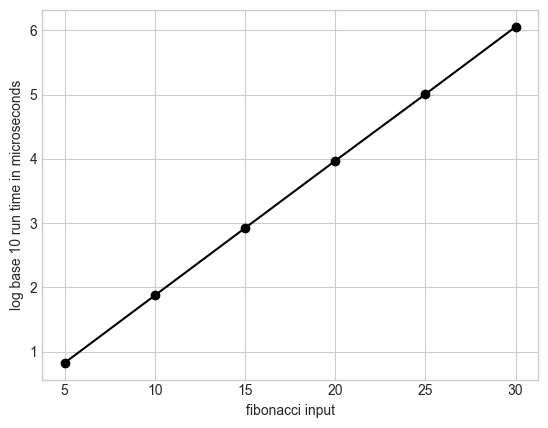

In [36]:
x = [5, 10, 15, 20, 25, 30]
y = [6.72, 75.2, 841, 9_360, 102_000, 1_140_000]
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.xlabel('fibonacci input')
plt.ylabel('log base 10 run time in microseconds')
from math import log
plt.plot(x, list(map((lambda p: log(p, 10)), y)), '-o', color='black');

Again we ask, "are we out of luck" for one-shot _fast_ Fibonacci? Again we answer, "No!"

Slow Fibonacci is slow because it recursively computes the same values over and over again. `fib(6)` has 24 sub-computations: `fib(5)` once, `fib(4)` twice, `fib(3)` thrice, `fib(2)` five times, `fib(1)` nine times, `fib(0)` five times. `fib(7)` has a copy of `fib(6)` -- 24 sub-calls -- and a copy of `fib(5)` -- 15 sub-calls. `fib(125)` has around $10^{25}$ sub-calls.

Let's replace repeated evaluations with table lookups, approximately constant time. We'll need a $\mathscr{Y}$ that can take two arguments: a running lookup table `a` -- for "assoc" -- and the numerical argument `n`.

# $\mathscr{Y}$ of Two Arguments

Currying makes it trivial to extend non-typed $\mathscr{Y}$ to any number of arguments.

```
(lambda d:
 (lambda g: g(g))
 (lambda sf:
  d(lambda m:
    (lambda n:  # <~~~ pile on more arguments
     (sf(sf))(m)(n)))))  # <~~~ call on them here
 (lambda f:  # <~~~ domain function of ...
  (lambda m:  # <~~~ ... the first argument and ...
   (lambda n:   # <~~~ ... more arguments
    -- business code that depends on f, m, n -- 
    )))
```

Writing types for lookup tables is more delicate. In a reversal of the prior development, we do the typed version first, then the untyped version.

# Fast Fib Types

In [37]:
from typing import Dict, Tuple

Let `ASSOC` be the type of the lookup table. We'll pass instances of this type to the parameter `m` for `MEMO`, paired with `int` values:

In [38]:
ASSOC = Dict[int, int]
MEMO = Tuple[ASSOC, int]

The rest of the types are 
1. `FIMEMO`, function from integer to memo
2. `FAFIMEMO`, function from assoc `A` to `int` $\rightarrow$ `MEMO`
3. `FAFIM2FAFIM`, function from a `FAFIMEMO` to a `FAFIMEMO`
4. `SQRT_FAFIMEMO`, function from `SQRT_FAFIMEMO`

In [39]:
FIMEMO = Callable[[int], MEMO]
FAFIMEMO = Callable[[ASSOC], FIMEMO]
FAFIM2FAFIM = Callable[[FAFIMEMO], FAFIMEMO]
SQRT_FAFIMEMO = Callable[["SQRT_FAFIMEMO"], FAFIMEMO]

## Fast Fib Domain Code

Except for the types, this is straightforward. It first checks the memo tables `a` and `a1` for presence of keys `n - 1` and `n - 2`,  via `in` expressions, then calls the recursive function `f` only when lookup fails. In that case, it updates the tables with new values so that recursive calls already on the stack can just look up results. It's best to analyze the types from the inside out, convincing ourselves that they can't be anything else.

In [40]:
def ff(f: FAFIMEMO) -> FAFIMEMO:
    """My type is FAFIM2FAFIM."""
    def fa(a: ASSOC) -> FIMEMO:
        """My type is FAFIMEMO."""
        def fn(n: int) -> MEMO:
            """My type is FIMEMO."""
            if n < 2:
                return a, 1
            else:
                if n - 1 in a:
                    a1 = a
                    r1 = a[n - 1]
                else:
                    a1, r1 = f(a)(n - 1)
                    a1[n - 1] = r1
                if n - 2 in a1:
                    a2 = a1
                    r2 = a1[n - 2]
                else:
                    a2, r2 = f(a1)(n - 2)
                    a2[n - 2] = r2
                result_fn: MEMO = (a2, r1 + r2)
                return result_fn
        result_fa: FIMEMO = fn
        return result_fa
    result_ff: FAFIMEMO = fa
    return result_ff

## Two-Argument Self-Apply

... is the same as one-argument self apply due to Currying, except for the types:

In [41]:
def self_apply_2(g: SQRT_FAFIMEMO) -> FAFIMEMO:
    result_gg: FAFIMEMO = g(g)
    return result_gg

## Two-Argument $\mathscr{Y}$

Again, except for the types, this is no different than the type-free version at the top of this section. 

In [42]:
def yc2(domain_code: FAFIM2FAFIM) -> FAFIMEMO:
    def lsf(sf: SQRT_FAFIMEMO) -> FAFIMEMO:
        def dmn(m: ASSOC) -> FIMEMO:
            """My type is FAFIMEMO."""
            def dn(n: int) -> MEMO:
                """My type is FIMEMO."""
                result_dn: MEMO = (sf(sf))(m)(n)
                return result_dn
            result_dm: FIMEMO = dn
            return result_dm
        result_lsf: FAFIMEMO = domain_code(dmn)
        return result_lsf
    result_y2c: FAFIMEMO = self_apply_2(lsf)
    return result_y2c

Check it:

In [43]:
yc2(ff)({})(6)

({1: 1, 0: 1, 2: 2, 3: 3, 4: 5, 5: 8}, 13)

Chop off the final dictionary:

In [44]:
yc2(ff)({})(6)[1]

13

Try it on an absurdly large argument (don't worry, it's instantaneous). The slow version would not complete in $10^{30}$ times the age of the Universe:

In [45]:
yc2(ff)({})(400)[1]

284812298108489611757988937681460995615380088782304890986477195645969271404032323901

## Python Recursion Limits

Python cannot optimize tail calls, so it runs out of execution stack at `yc2(ff)({})(500)`. The type-free version, below, runs out at around 250 because it has more internal functions to replace the statement logic in the business code `ff.fa.fn` above. 

# Fast Fib with No `def`s

We'll show it at work, first, then explain how we derived it.

In [46]:
((lambda d:  # This is yc2; d is the domain code.
  (lambda g: g(g))  # self-apply-2
  (lambda sf:  # square root of recursion
   d(lambda m:  # Call the domain code with the buesiness code,
     (lambda n:  # which is Curried over two arguments. 
      (sf(sf))(m)(n)))))
((lambda f:  # ordinary signature of domain code
  (lambda a:  # two-argument business code ...
   (lambda n:  # ...
    (a, 1) if n < 2 else  # early escapt
    ((lambda n_1:
      (a, a[n_1]) if n_1 in a else  # check the memo's assoc
      ((lambda fim1:  # function from integer to memo
        ((lambda m1:  # memo = (assoc, int)
          ((lambda r1:  # int
            ((lambda a1:  # assoc 
              ((lambda n_2:  # DRY
                (a1, r1 + a1[n_2]) if n_2 in a1 else  # check memo
                ((lambda fim2:  # function from integer to memo
                  ((lambda m2:  # memo = (assoc, int)
                    ((lambda r2:  # int
                      ((lambda a2:  # assoc
                        (a2, r1 + r2))  # final answer
                       (m2[0] | {n_2: r2})))  # merge the assoc
                     (m2[1])))  # fetch an int from the memo
                   (fim2(n_2))))  # compute memo from int
                 (f(a1))))  # compute fim2 from assoc 1
               (n - 2)))  # DRY
             (m1[0] | {n_1: r1})))  # merge the assoc
           (m1[1])))  # fetch an int from the memo
         (fim1(n_1))))  # compute memo from int
       (f(a))))  # compute fim1 from input assoc {}
     (n - 1)  # DRY
    ))))))({})(250)[1]

12776523572924732586037033894655031898659556447352249

## A Torture Test for Humans and for Compilers

Ok, I hope you're laughing at me, now. However, this is exactly the kind of expression we'd expect to see inside a Python compiler that converted the statement logic of `ff.fa.fn` into expressions. It's NOT just an intellectual exercise! It's a torture test for compilers. 

However, it's practically impossible to get this absurd expression right with fingers on the keyboard, without some kind of mechanical help. For that help, I went to Clojure and Emacs which balances parentheses easily. I hope you'll see that the following Clojure domain code is a straight transcription of the Python `ff.fa.fn` above. It was easy to write, though a little unnatural because of the Currying. I won't walk through it, but I'll show how it unpacks into the monster above.

```clojure
(def dafib
  (fn [f]
    (fn [a]   ;; an ASSOC :: int -> int
      (fn [n] ;; :: int
        (if (< n 2N)
          [a, 1N] ;; :: MEMO = [ASSOC, Integer]
          (let [n-1 (- n 1N)]
            (if (a n-1)    ;; membership check
              [a, (a n-1)] ;; early return
              (let [fim1 (f a)
                    m1 (fim1 n-1)
                    r1 (m1 1) ;; pick element 1 of m1
                    a1 (merge (m1 0) {n-1 r1})
                    n-2 (- n 2)]
                (if (a1 n-2)            ;; membership check
                  [a1, (+ r1 (a1 n-2))] ;; early return
                  (let [fim2 (f a1)
                        m2 (fim2 n-2)
                        r2 (m2 1) ;; pick elt. 1 of m2
                        a2 (merge (m2 0) {n-2 r2})]
                    [a2, (+ r1 r2)]))))))))))
```

Python has no _let_ (except, see [this gist](https://gist.github.com/divs1210/d218d4b747b08751b2a232260321cdeb)). But `(let [x V] E)` is precisely `((lambda x: E)(V))`, and that's it, that's how we get all the nested lambdas.

> The "_mechanical help_" that balances parentheses in Emacs is a nearly-miraculous thing called [paredit](https://emacsrocks.com/e14.html). I know of nothing even close elsewhere. I consider it sufficient reason to learn Emacs.